In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [85]:
def plotMoment(filepath, save=False, vmin=None, vmax=None):
    from astropy.io import fits
    import aplpy as apl
    
    bunit = fits.open(filepath)[0].header['BUNIT']
    im = apl.FITSFigure(filepath, north=True)
    im.frame.set_linewidth(2)
    im.frame.set_color('black')
    cmap = plt.cm.viridis
    im.show_colorscale(cmap=cmap, stretch='sqrt', vmin=vmin, vmax=vmax)

    im.set_nan_color('white')
    im.tick_labels.set_font(size=18)

    im.add_colorbar()
    im.colorbar.set_font(size=18)
    im.colorbar.set_axis_label_text('Intensity ['+bunit+']')
    im.colorbar.set_axis_label_font(size=18)
    im.colorbar.set_frame_linewidth(2)
    # im.tick_labels.set_xformat('hh:mm:ss')
    # im.tick_labels.set_yformat('dd:mm:ss')
    im.ticks.set_xspacing('auto')
    im.ticks.set_yspacing('auto')
    im.axis_labels.set_font(size=18)
    im.ticks.set_linewidth(2)
    im.ticks.set_color('black')

#     im.show_markers(center.ra.degree, center.dec.degree, marker='+', c='white', s=120, linewidth=2)

    if save:
        im.save(filepath.split('.fits')[0]+'.pdf', format='pdf', transparent=True, dpi=300)

In [78]:
from spectral_cube import SpectralCube
import numpy as np
import aplpy as apl
import matplotlib.pyplot as plt

almadir = '/Volumes/SD-Mac/Google Drive/research/bhr71_infall/analysis/imcontsub/'
spws = np.arange(0,4).astype('str')
vlsr = -4.45

/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:2031: UserWarning: Cube is a Stokes cube, returning spectral cube for I component
  warnings.warn("Cube is a Stokes cube, "


INFO: Auto-setting vmin to -1.930e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.465e+03 [aplpy.core]
INFO: Auto-setting vmin to -1.919e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.160e+03 [aplpy.core]
INFO: Auto-setting vmin to -1.428e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.006e+03 [aplpy.core]
INFO: Auto-setting vmin to -1.631e+02 [aplpy.core]
INFO: Auto-setting vmax to  8.124e+02 [aplpy.core]


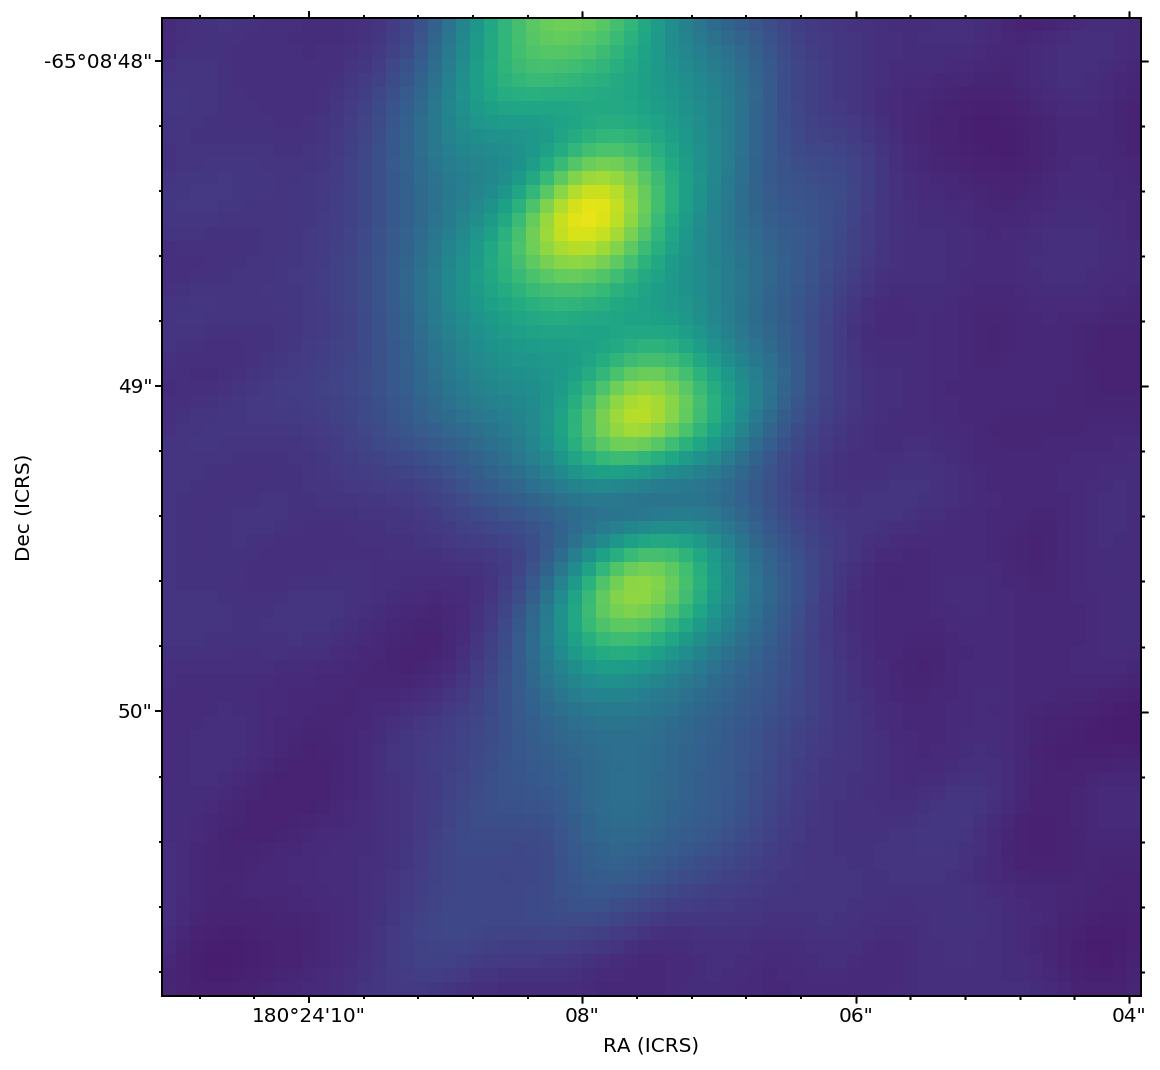

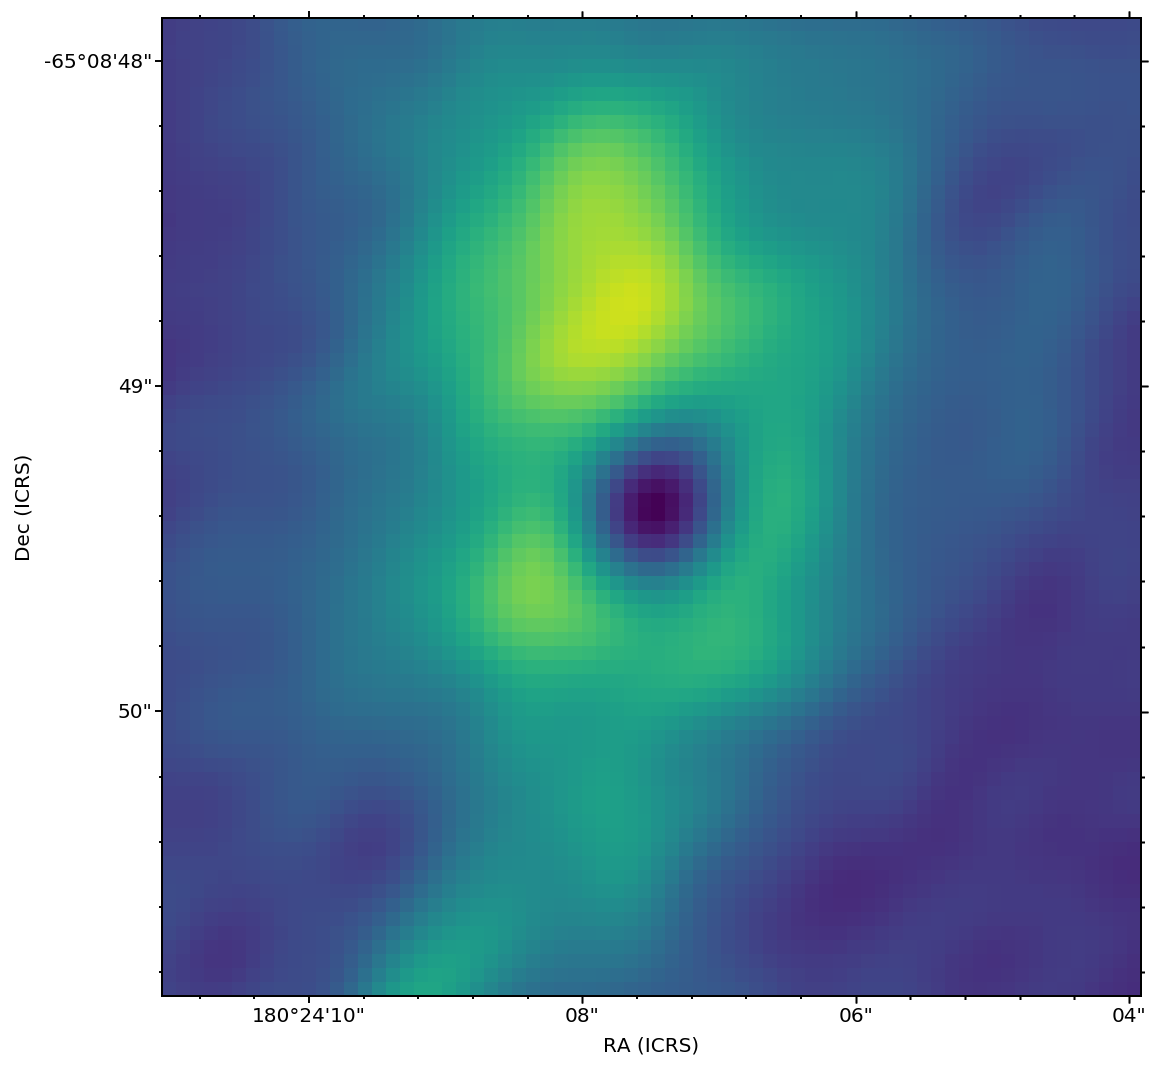

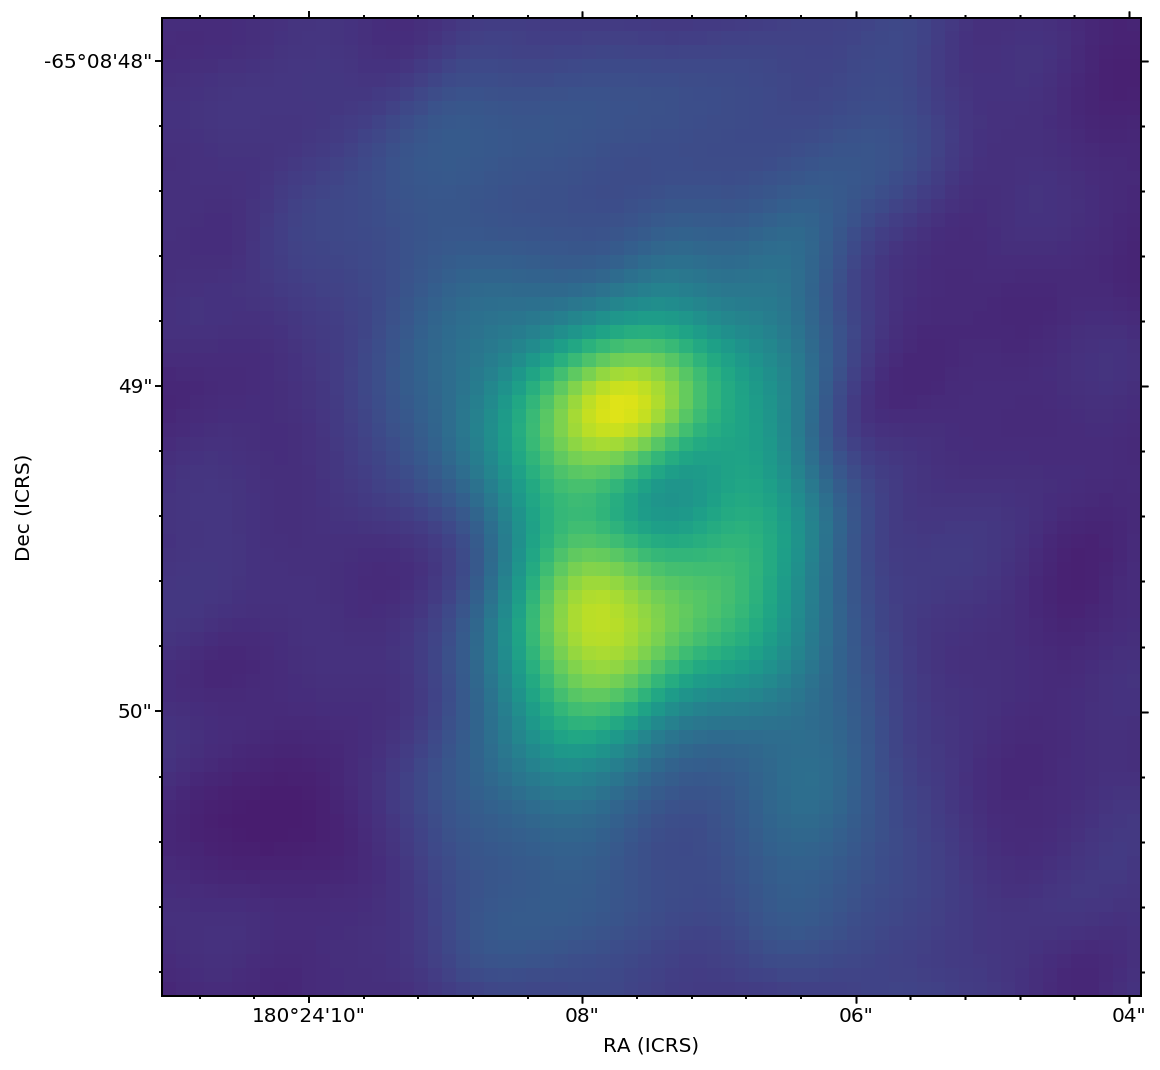

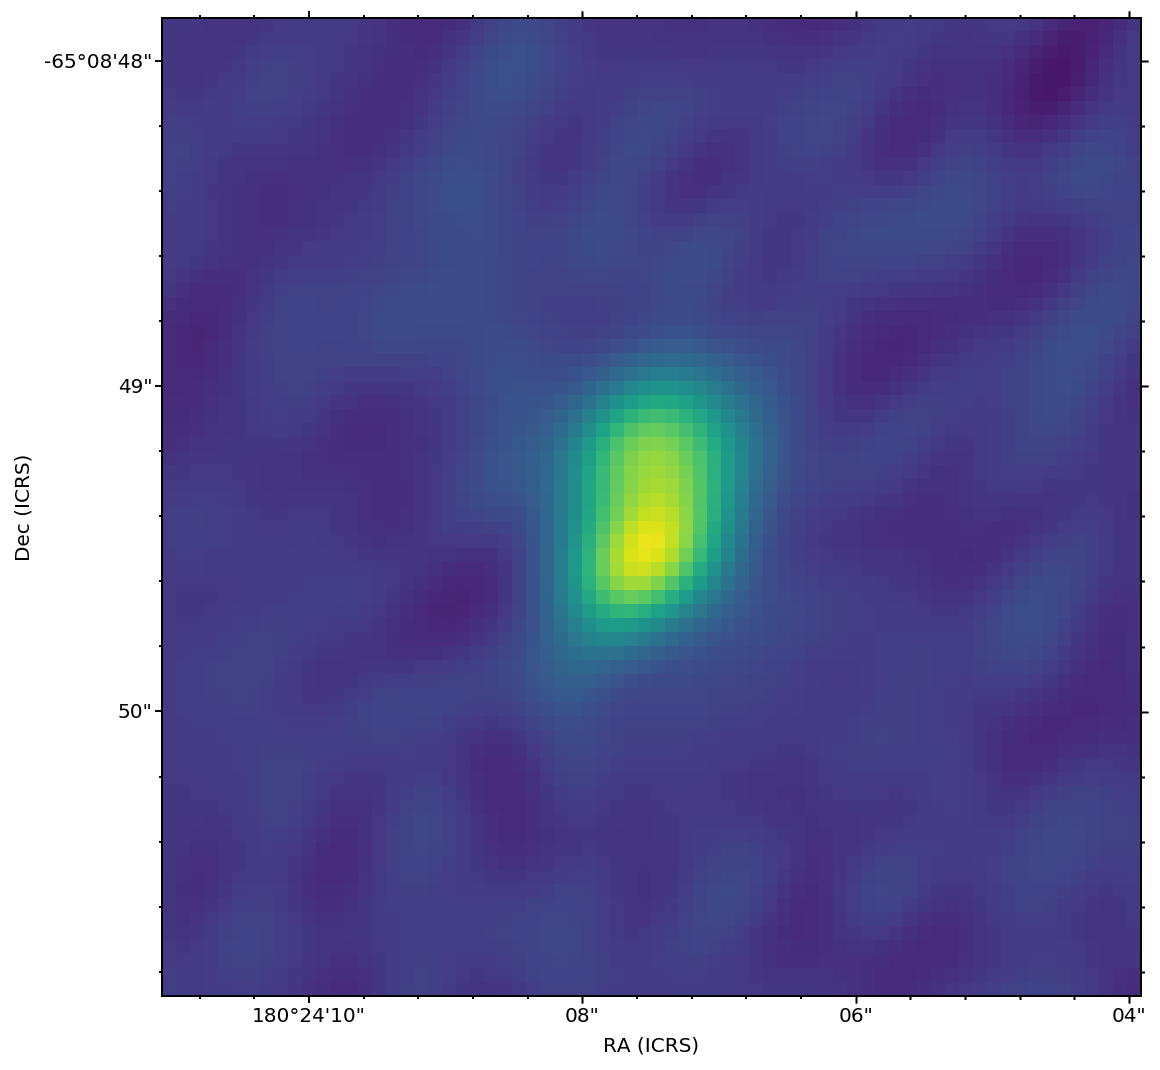

In [90]:
for i, spw in enumerate(spws):
    img = almadir+'spw'+spw+'_imcontsub.image.pbcor.fits'
    cube = SpectralCube.read(img) 
    slab = cube.spectral_slab((vlsr-10) * u.kilometer/u.second, (vlsr+10) * u.kilometer/u.second)  
    
    moment_0 = slab.moment(order=0)
    moment_1 = slab.moment(order=1)
    moment_0.write(img.split('.fits')[0]+'.moment0.fits', overwrite=True)
    moment_1.write(img.split('.fits')[0]+'.moment1.fits', overwrite=True)
    
    f = apl.FITSFigure(moment_0.hdu)
    f.show_colorscale()
#     f.save('moment_0.png')

In [121]:
from pvextractor import PathFromCenter, extract_pv_slice
from astropy import units as u
from astropy.coordinates import SkyCoord
g = SkyCoord(180.40207844*u.deg, -65.14705054*u.deg)
path = PathFromCenter(center=g, length=3 * u.arcsec, angle=124.91 * u.deg, width=0.5 * u.arcsec)
slice = extract_pv_slice(almadir+'spw3_imcontsub.image.pbcor.fits', path)
slice.writeto(almadir+'spw3_imcontsub.image.pbcor.pv.fits', overwrite=True)  

/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:2031: UserWarning: Cube is a Stokes cube, returning spectral cube for I component
  warnings.warn("Cube is a Stokes cube, "


In [195]:
def getPV(filepath):
    from pvextractor import PathFromCenter, extract_pv_slice
    from astropy import units as u
    from astropy.coordinates import SkyCoord
    g = SkyCoord(180.40207844*u.deg, -65.14705054*u.deg)
    path = PathFromCenter(center=g, length=3 * u.arcsec, angle=124.91 * u.deg, width=0.5 * u.arcsec)
    slice = extract_pv_slice(filepath, path)
    slice.writeto(filepath.split('.fits')[0]+'.pv.fits', overwrite=True)
    
    pv_file = filepath.split('.fits')[0]+'.pv.fits'
    hdu = fits.open(pv_file)
    hdu[0].header
    
    velo_range = [vlsr-5, vlsr+5]
    velo_im = ((np.arange(hdu[0].header['NAXIS2'])-hdu[0].header['CRPIX2']-1)*hdu[0].header['CDELT2']+hdu[0].header['CRVAL2'])/1e3
    selector = (velo_im >= velo_range[0]) & (velo_im <= velo_range[1])

    offset_im = ((np.arange(hdu[0].header['NAXIS1'])-hdu[0].header['CRPIX1']-1)*hdu[0].header['CDELT1']+hdu[0].header['CRVAL1'])*3600
    center_offset = (offset_im[0]+offset_im[-1])/2
    offset_select = (offset_im >= center_offset-1) & (offset_im <= center_offset+1)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.imshow(hdu[0].data[selector, :][:, offset_select],
              extent=[offset_im[offset_select].min(), offset_im[offset_select].max(), velo_im[selector].min(), velo_im[selector].max()])
    ax.axhline(vlsr, color='w', linestyle='--')
    ax.set_aspect(1/10)

    ax.set_xlabel('offset [arcsec]', fontsize=18)
    ax.set_ylabel('velocity [km s$^{-1}$]', fontsize=18)
    ax.minorticks_on()
    [ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
    ax.tick_params('both',labelsize=16,width=1.5,which='major',pad=5,length=5)
    ax.tick_params('both',labelsize=16,width=1.5,which='minor',pad=5,length=2.5)

    fig.savefig(filepath.split('.fits')[0]+'.pv.pdf', format='pdf', dpi=300, bbox_inches='tight')

/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:2031: UserWarning: Cube is a Stokes cube, returning spectral cube for I component
  warnings.warn("Cube is a Stokes cube, "


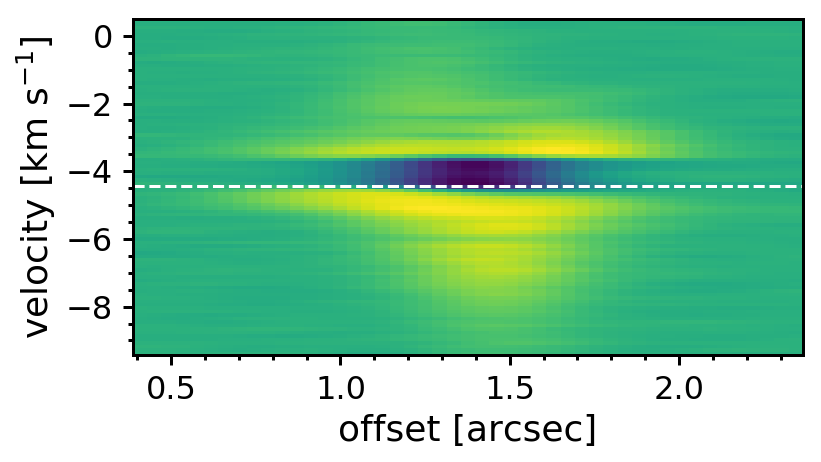

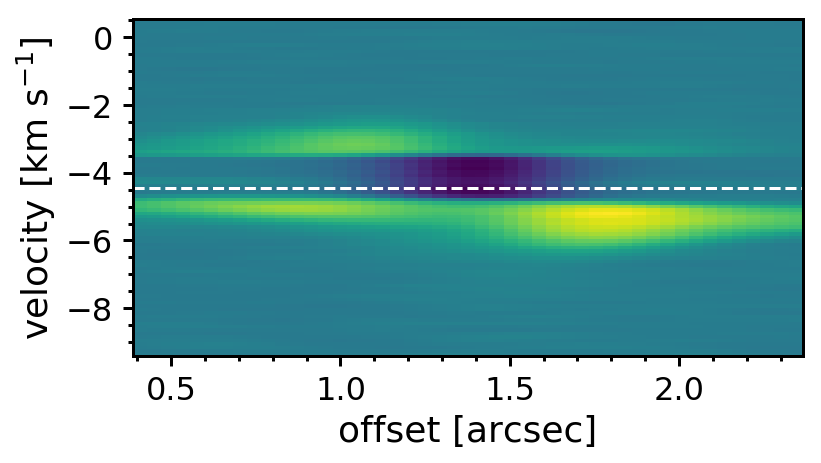

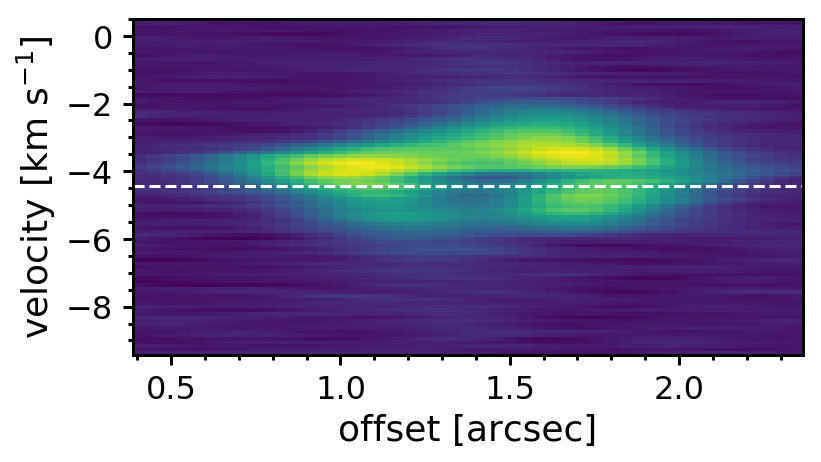

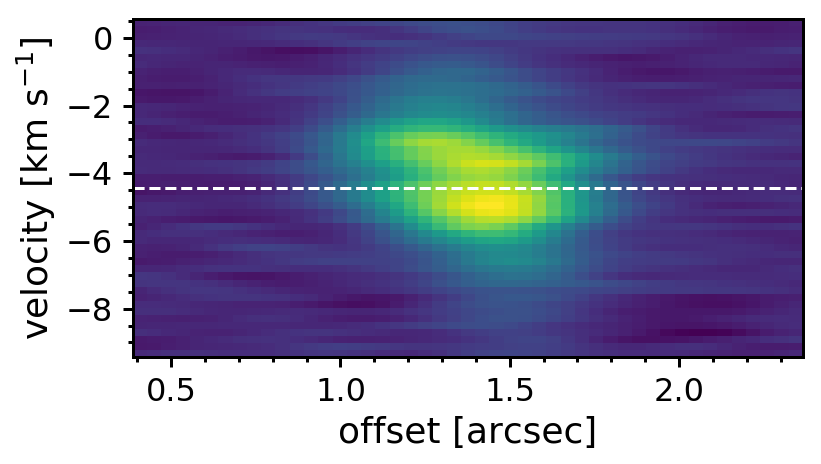

In [196]:
for spw in spws:
    getPV(almadir+'spw'+spw+'_imcontsub.image.pbcor.fits')

### Compare with CASA result

In [173]:
from pvextractor import Path, extract_pv_slice
# path = Path([(59.5, 36.2), (7.2, 31.6)], width=1)
# slice = extract_pv_slice(almadir+'spw3_imcontsub.image.pbcor.fits', path)
from astropy.coordinates import ICRS
points = ICRS(['12h01m36.331s', '12h01m36.688s'], ['-65d08m49.279s', '-65d08m49.478s'])
# points = [SkyCoord(ra='12 01 36.331'*u.hourangle, dec='-65 08 49.279'*u.deg, rame='icrs'),
#           SkyCoord('12 01 36.688 -65 08 49.478', unit=(u.hourangle, u.deg), frame='icrs')]
path2 = Path(points, width=1)
slice = extract_pv_slice(almadir+'spw3_imcontsub.image.pbcor.fits', path2)

/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:2031: UserWarning: Cube is a Stokes cube, returning spectral cube for I component
  warnings.warn("Cube is a Stokes cube, "


In [193]:
filepath = almadir+'spw3_imcontsub.image.pbcor.fits'
slice.writeto(filepath.split('.fits')[0]+'.pv.casa.fits', overwrite=True)

pv_file = filepath.split('.fits')[0]+'.pv.casa.fits'
hdu = fits.open(pv_file)
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   52                                                  
NAXIS2  =                 1919                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                  1.0 / Pixel coordinate of reference point            
CRPIX2  =                  1.0 / Pixel coordinate of reference point            
CDELT1  =   1.194444444444E-05 / [deg] Coordinate increment at reference point  
CDELT2  =      -211.9437089716 / [m s-1] Coordinate increment at reference point
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'm s-1'              / Units of coordinate increment and value        
CTYPE1  = 'OFFSET'          

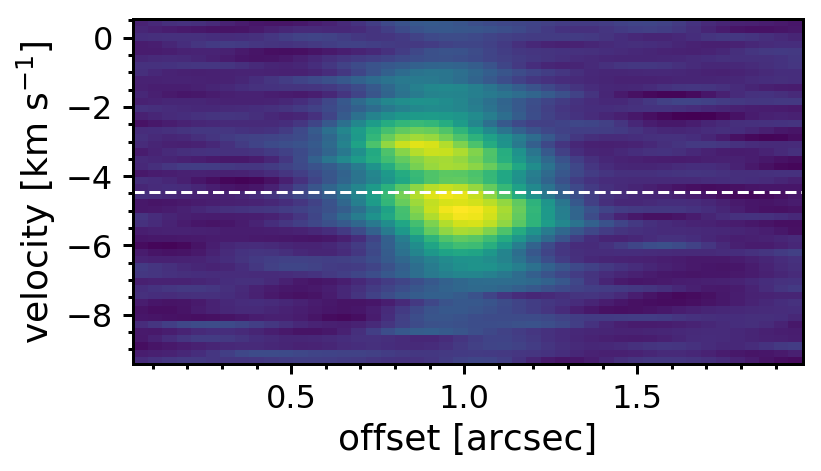

In [194]:
velo_range = [vlsr-5, vlsr+5]
velo_im = ((np.arange(hdu[0].header['NAXIS2'])-hdu[0].header['CRPIX2']-1)*hdu[0].header['CDELT2']+hdu[0].header['CRVAL2'])/1e3
selector = (velo_im >= velo_range[0]) & (velo_im <= velo_range[1])

offset_im = ((np.arange(hdu[0].header['NAXIS1'])-hdu[0].header['CRPIX1']-1)*hdu[0].header['CDELT1']+hdu[0].header['CRVAL1'])*3600
center_offset = (offset_im[0]+offset_im[-1])/2
offset_select = (offset_im >= center_offset-1) & (offset_im <= center_offset+1)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(hdu[0].data[selector, :][:, offset_select],
          extent=[offset_im[offset_select].min(), offset_im[offset_select].max(), velo_im[selector].min(), velo_im[selector].max()])
ax.axhline(vlsr, color='w', linestyle='--')
ax.set_aspect(1/10)

ax.set_xlabel('offset [arcsec]', fontsize=18)
ax.set_ylabel('velocity [km s$^{-1}$]', fontsize=18)
ax.minorticks_on()
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.tick_params('both',labelsize=16,width=1.5,which='major',pad=5,length=5)
ax.tick_params('both',labelsize=16,width=1.5,which='minor',pad=5,length=2.5)

fig.savefig(filepath.split('.fits')[0]+'.pv.casa.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [190]:
velo_im

array([ 196.59202883,  196.38008512,  196.16814141, ..., -209.49211756,
       -209.70406127, -209.91600498])

In [181]:
from astropy.io import ascii
spec = ascii.read('/Volumes/SD-Mac/Google Drive/research/bhr71_infall/analysis/imcontsub/spw3.imcontsub.scriptExtraction.txt')

In [182]:
spec['col4'].min(), spec['col4'].max()

(-210.05430799999999, 196.44440499999999)